In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sktime.utils.plotting import plot_series
from sktime.utils import plot_windows
from sktime.datasets import load_airline
from sktime.transformations.series.lag import Lag
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    temporal_train_test_split,
    ForecastingGridSearchCV,
    ForecastingRandomizedSearchCV
)
from sktime.transformations.compose import (
    Id,
    OptionalPassthrough,
    ColumnwiseTransformer,
    TransformerPipeline
)
from sktime.performance_metrics.forecasting import (
    MeanSquaredScaledError,
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error
)
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.compose._reduce import DirectTabularRegressionForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_evaluation import evaluate


import sktime_recipe as sktr

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Part 1: Defining Recipe Components

In [29]:
# define data importer
def airpass_import_data(self,start_dt,end_dt):

    # import y
    y = load_airline()
    y = y[np.logical_and(y.index>=start_dt,y.index<=end_dt)]
    y = pd.DataFrame(y,index = y.index)
    y = y.rename(columns={'Number of airline passengers':'pass_count'})

    # import X
    X = pd.read_csv('UNRATE.csv')
    X['Period'] = pd.to_datetime(X['observation_date'])
    X = X.set_index('Period')
    X.index = X.index.to_period('M')
    X = X.drop(columns=['observation_date'])
    X = X[np.logical_and(X.index>=start_dt,X.index<=end_dt)]

    # merge
    df = pd.merge(y,X,how='left',left_index=True,right_index=True)

    return df

In [30]:
# define misc data preprocessing
def airpass_misc_preprocessing(self,data):
    # nothing for this example
    return data

In [31]:
# create exogenous features for which future values are known
def airpass_create_known_X(self,X_index):
    known_X = pd.DataFrame(index=X_index)
    known_X['month'] = known_X.index.month
    return known_X

In [32]:
def airpass_y_core_forecaster_xgb():

    forecaster = DirectTabularRegressionForecaster(
        estimator = xgb.XGBRegressor(),
        window_length=12
        )
    hyperparam_search_space = {
        'window_length':[1,3,6,12],
        'estimator__n_estimators':[50,100,300]
        }

    return forecaster, hyperparam_search_space

In [33]:
def airpass_y_transpipe():
    transforms = [
        ('log',OptionalPassthrough(LogTransformer(offset=1))),
        ('differencer',OptionalPassthrough(Differencer(lags=[1,12]))),
        ('detrend',OptionalPassthrough(
            Detrender(forecaster=ExponentialSmoothing(
                seasonal='add',
                trend='add',
                sp=12
                )),
            passthrough=False
            ))
    ]
    hyper_search_space = {
        'log__passthrough':[True,False],
        'differencer__passthrough':[True,False],
        'differencer__transformer__lags':[1,12,[1,12]],
        'detrend__passthrough':[True,False],
        'detrend__transformer__forecaster__seasonal':['add','mul',None],
        'detrend__transformer__forecaster__trend':['add','mul',None]
        }
    return transforms, hyper_search_space

In [34]:
from sktime.forecasting.naive import NaiveForecaster

# forecaster for unknown X
def airpass_X_core_forecaster_naive():
    forecaster = NaiveForecaster(sp=1)
    hyperparam_search_space = {}
    return forecaster, hyperparam_search_space

In [35]:
from sktime.transformations.series.lag import Lag

# note -- this is more complex than the y transpipe, so use help of another class, XTranspipeSpec
# like the other components, this is added to the recipe later

# transformation pipeline for X
airpass_X_transpipe = sktr.XTranspipeSpec()

#lag transform (need to lag 1 period due to delay in unemployment data release)
airpass_X_transpipe.add_X_transform(
    transform = ('lag',Lag(1)),
    trans_cols = 'Unknown',
    hyper_search_space = {}
    )

#log transform
airpass_X_transpipe.add_X_transform(
    transform = ('log',OptionalPassthrough(LogTransformer(offset=1))),
    trans_cols = 'Unknown',
    hyper_search_space = {
        'log__passthrough':[True,False],
        'log__transformer__offset':[1]
        }
    )

#differencer
airpass_X_transpipe.add_X_transform(
    transform = ('differencer',OptionalPassthrough(Differencer(lags=1))),
    trans_cols = 'Unknown',
    hyper_search_space = {
        'differencer__passthrough':[True, False],
        'differencer__transformer__lags':[7]
        }
    )

### Part 2: Build Recipe Object

In [36]:
# set recipe params (note: show yaml file example for actual cash forecasting recipe)
recipe_params = {}
recipe_params['name'] = 'airpass'
recipe_params['X_known'] = ['month']
recipe_params['X_unknown'] = ['UNRATE']
recipe_params['target'] = 'pass_count'
recipe_params['ts_freq'] = 'M'
recipe_params['forecast_horizon'] = 12

In [37]:
# create recipe object
recipe = sktr.ForecastingRecipe(
    **recipe_params,
    data_importer = airpass_import_data,
    data_preprocessor = airpass_misc_preprocessing,
    known_feature_creator = airpass_create_known_X,
    )

vars(recipe)

{'name': 'airpass',
 'target': 'pass_count',
 'forecast_horizon': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 'ts_freq': 'M',
 'X_known': ['month'],
 'X_unknown': ['UNRATE'],
 'y_core_forecaster': None,
 'y_core_forecaster_hyper_search_space': {},
 'y_trans_hyper_search_space': {},
 'y_transpipe': [('id', Id())],
 'X_core_forecaster': None,
 'X_core_forecaster_hyper_search_space': {},
 'X_transpipe': [('id', Id())],
 'X_trans_hyper_search_space': {},
 'forecaster': None,
 'hyperparam_search_space': None,
 'data_importer': <bound method airpass_import_data of <sktime_recipe_v2.ForecastingRecipe object at 0x000001F1F00D44F0>>,
 'data_preprocessor': <bound method airpass_misc_preprocessing of <sktime_recipe_v2.ForecastingRecipe object at 0x000001F1F00D44F0>>,
 'known_feature_creator': <bound method airpass_create_known_X of <sktime_recipe_v2.ForecastingRecipe object at 0x000001F1F00D44F0>>,
 'aggregate': False,
 'reconciler_method': None}

In [38]:
# add y core forecaster information (forecaster and hyperparams)
recipe.update_y_core_forecaster_attributes(airpass_y_core_forecaster_xgb())

# add y transformation information (transforms and hyperparams)
recipe.update_y_transpipe_attributes(airpass_y_transpipe())

# add X core forecaster information
recipe.update_X_core_forecaster_attributes(airpass_X_core_forecaster_naive())

# add X transformations (more complex, argument is obj from custom class rather than tuple like the others)
recipe.update_X_transpipe_attributes(airpass_X_transpipe)

{}


In [39]:
recipe.build_full_pipeline()

recipe.forecaster

ForecastX(columns=['UNRATE'], fit_behaviour='use_forecast',
          forecaster_X=ForecastingPipeline(steps=[FeatureUnion(transformer_list=[('TransformerPipeline_0',
                                                                                  TransformerPipeline(steps=[ColumnSelect(columns=['UNRATE']),
                                                                                                             ('lag',
                                                                                                              Lag(lags=1))])),
                                                                                 ('TransformerPipeline_1',
                                                                                  TransformerPipeline(steps=[ColumnSelect(columns=['UNRATE']),
                                                                                                             ('log',
                                                                                                              OptionalPassthrough(t...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...),
                                                                                             window_length=12))]))

# Part 3: Train Forecaster

In [40]:
# set training params
params = {}
params['start_dt'] = '1949-03-01'
params['end_dt'] = '1961-01-01'
params['min_train_size'] = 0.6
params['n_cv_folds'] = 5
params['n_cv_iter'] = 80

In [41]:
# load data
df = recipe.data_importer(start_dt = params['start_dt'],end_dt=params['end_dt'])

In [42]:
# process data
y, X = recipe.preprocess_data(df, start_dt = params['start_dt'])

In [43]:
y.head()

,pass_count
Period,
1949-03,132.0
1949-04,129.0
1949-05,121.0
1949-06,135.0
1949-07,148.0


In [45]:
X.head()

,UNRATE,month
1949-03,5.0,3
1949-04,5.3,4
1949-05,6.1,5
1949-06,6.2,6
1949-07,6.7,7


In [46]:
# #split into train and test
y_train, y_test, X_train, X_test = (
    temporal_train_test_split(y=y,X=X,test_size=max(recipe.forecast_horizon))
    )

In [48]:
# create time series cv generators
total_train_periods = len(y_train.index)
initial_window = round(total_train_periods*params['min_train_size'],0)
cv_step_size = np.floor((total_train_periods-initial_window)/params['n_cv_folds'])

# create cv generator
cv_gen = ExpandingWindowSplitter(
    fh = recipe.forecast_horizon,
    initial_window = int(initial_window),
    step_length = int(cv_step_size)
    )

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

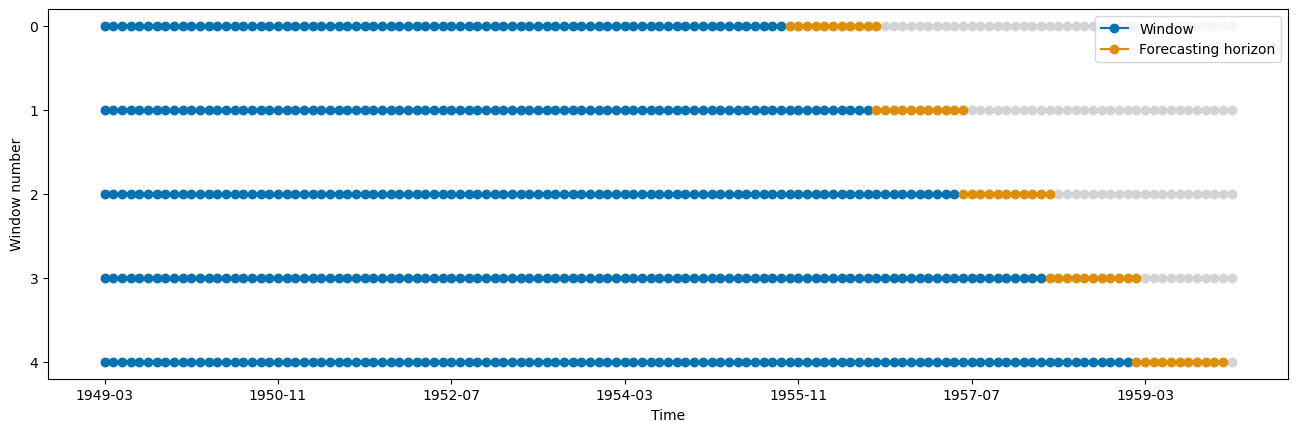

In [49]:
plot_windows(cv=cv_gen,y=y_train)

In [50]:
# define cv search object
cv_search = ForecastingRandomizedSearchCV(
    forecaster = recipe.forecaster,
    param_distributions = recipe.hyperparam_search_space,
    cv=cv_gen,
    verbose=1,
    scoring=MeanAbsolutePercentageError(), #MeanSquaredScaledError(square_root=True),
    n_iter=params['n_cv_iter'],
    strategy='refit',
    #error_score='raise'
    error_score=1
    )


In [51]:
# fit cv search object
cv_search.fit(y=y_train,
              X=X_train,
              fh=recipe.forecast_horizon)

cv_search.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


{'forecaster_y__log__passthrough': False,
 'forecaster_y__forecaster__window_length': 1,
 'forecaster_y__forecaster__estimator__n_estimators': 50,
 'forecaster_y__differencer__transformer__lags': 12,
 'forecaster_y__differencer__passthrough': True,
 'forecaster_y__detrend__transformer__forecaster__trend': 'add',
 'forecaster_y__detrend__transformer__forecaster__seasonal': 'mul',
 'forecaster_y__detrend__passthrough': False,
 'forecaster_X__FeatureUnion__TransformerPipeline_2__differencer__transformer__lags': 7,
 'forecaster_X__FeatureUnion__TransformerPipeline_2__differencer__passthrough': True,
 'forecaster_X__FeatureUnion__TransformerPipeline_1__log__transformer__offset': 1,
 'forecaster_X__FeatureUnion__TransformerPipeline_1__log__passthrough': True}

In [52]:
# get cv results for only best forecaster
best_forecaster_cv_result = evaluate(
    forecaster=cv_search.best_forecaster_,
    y=y_train,
    X=X_train,
    cv=cv_gen,
    strategy="refit",
    scoring = MeanAbsolutePercentageError(),
    return_data=True
    )

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pass_count'>)

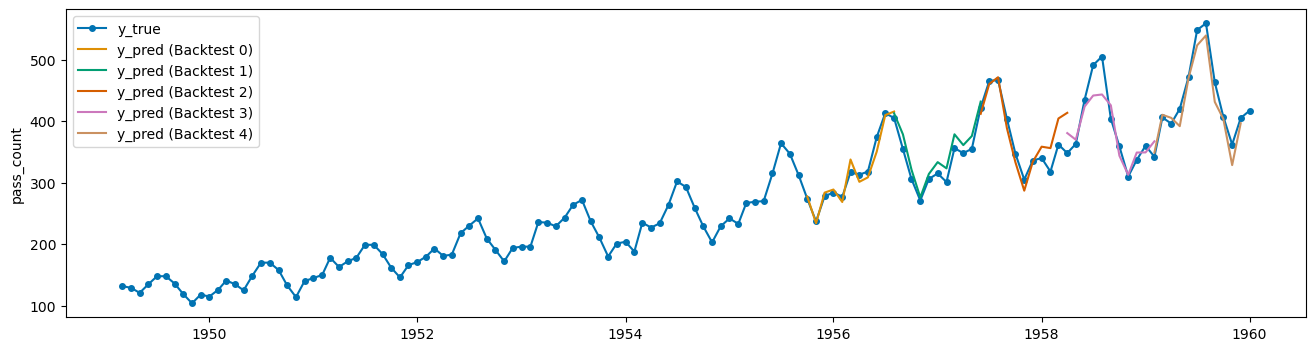

In [53]:
plot_series(
    y_train,
    *best_forecaster_cv_result["y_pred"].iloc[:5],
    markers=["o"] + [""] * 5,
    labels=["y_true"] + [f"y_pred (Backtest {x})" for x in range(5)]
)